# Advanced Cloud Clearing in Sentinel-2: combining spectral and clustering approaches

Our goal here is to prepare a Sentinel-2 image over a region of interest and create a cloud-clearing function that uses both:
- Spectral characteristics of clouds (e.g., high reflectance in blue, low in SWIR)
- A clustering algorithm (e.g., k-means or DBSCAN on pixel features) to find and expand cloud-masked areas to include neighboring “cloudy-ish” pixels.

My intent is that by the end of this lab you have a function that you can then use in many of your project workflows to ensure that the data you are using is as free of clouds as possible (you will need to re-design it if apply to imagery other than Sentinel 2).

The overview of our workflow is to:
- Load and filter Sentinel-2 surface reflectance imagery in Earth Engine.
- Apply the s2cloudless cloud probability algorithm.
- Apply a clustering approach to detect “borderline” cloudy pixels near heavy clouds.
- Generate a clean composite for a chosen date range.

We are using this tutorial from Google as the basis of our work: [Sentinel-2 Cloud Masking with s2cloudless](https://developers.google.com/earth-engine/tutorials/community/sentinel-2-s2cloudless).


**NOTE: in this lab whenever we ask you for an visual output, we are expecting you to present it to a publication quality level.**


________________________________________________________________________________
# Implementing S2 Cloudless

In [195]:
import geemap
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans

if 'google.colab' in str(get_ipython()):
    from google.colab import userdata
    EE_PROJECT_ID = userdata.get('EE_PROJECT_ID') 
else:
    from dotenv import load_dotenv
    import os
    load_dotenv()  # take environment variables
    EE_PROJECT_ID = os.getenv('EE_PROJECT_ID')

# Set up GEE API
import ee
ee.Authenticate()
ee.Initialize(project=EE_PROJECT_ID) #<- Remember to change this to your own project's name!

First, let us define our area of interest (AOI) and the cloud mask parameters: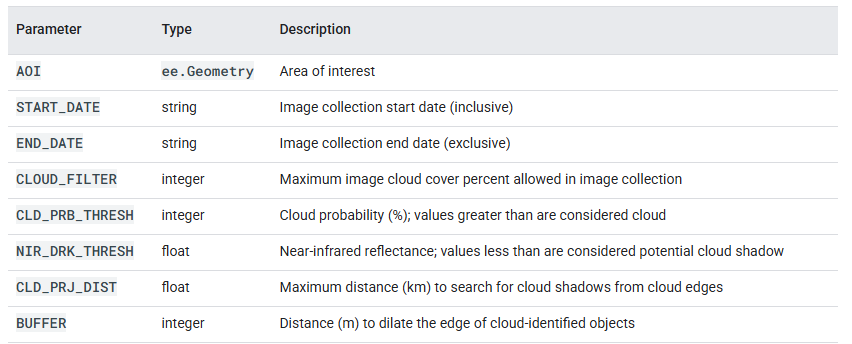

In [196]:
# Control variables
AOI = ee.Geometry.Point(174.7633, -36.8485)
START_DATE = '2023-01-01'
END_DATE = '2023-03-31'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50

Next we use these variables to build a Sentinel 2 image collection. You have done all this before, but now we are using more of the tools at our disposal to get exactly what we want.

Also, from now on we are going to be using functions to make our code more useable and extensible:

In [197]:
def get_s2_sr_cld_col(aoi=AOI, start_date=START_DATE, end_date=END_DATE, cloud_filter=CLOUD_FILTER):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', cloud_filter)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

In [198]:
# Apply the function in order to generate the collection
s2_sr_cld_col_eval = get_s2_sr_cld_col()

In [199]:
# As ever, a good idea to do a quick viusalization check
Map = geemap.Map()
Map.centerObject(AOI, 10)
Map.addLayer(s2_sr_cld_col_eval, {'bands':['B4','B3','B2'], 'min':0, 'max':3000}, 'S2 collection (before)')
Map

Map(center=[-36.84850000000001, 174.7633], controls=(WidgetControl(options=['position', 'transparent_bg'], pos…

Yup that is pretty cloudy!

Now, we will define a function to add the s2cloudless probability layer and derived cloud mask as bands to an S2 SR image input.

In [200]:
def add_cloud_bands(img, cld_prb_thresh=CLD_PRB_THRESH):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(cld_prb_thresh).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

The next function we need adds bands that add dark pixels, cloud projection, and identified shadows as bands to an S2 SR image input. Note that the image input needs to be the result of the above add_cloud_bands function because it relies on knowing which pixels are considered cloudy (via the renamed 'CLD_PRB_THRESH' band native to this S2 product).

In [201]:
def add_shadow_bands(img, nir_drk_thresh=NIR_DRK_THRESH, cld_prj_dist=CLD_PRJ_DIST):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(nir_drk_thresh * SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, cld_prj_dist * 10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

Finally for this stage, we define a function to assemble all of the cloud and cloud shadow components and produce the final mask.

In [ ]:
def add_cld_shdw_mask(img, cld_prb_thresh=CLD_PRB_THRESH, nir_drk_thresh=NIR_DRK_THRESH, cld_prj_dist=CLD_PRJ_DIST, buffer=BUFFER):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img, cld_prb_thresh=cld_prb_thresh)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud, nir_drk_thresh=nir_drk_thresh, cld_prj_dist=cld_prj_dist)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by buffer input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(buffer*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))
    
    # is_cld_shdw = (is_cld_shdw.rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

Let us check this out and see how well it is dealing with our famously cloudy country. To do this we will need a function to pull out the cloud masking component layers, as in the 'final' version we will just apply this layer to remove the clouds rather than hold it as something we will display.

In [203]:
def display_cloud_layers_geemap(col, aoi=AOI):
    # Mosaic the image collection.
    img = col.mosaic()

    # Subset layers and prepare them for display.
    clouds = img.select('clouds').selfMask()
    shadows = img.select('shadows').selfMask()
    dark_pixels = img.select('dark_pixels').selfMask()
    probability = img.select('probability')
    cloudmask = img.select('cloudmask').selfMask()
    cloud_transform = img.select('cloud_transform')

    # Create a geemap Map object centered on AOI.
    m = geemap.Map()
    m.centerObject(aoi, 12)

    # Add layers
    m.addLayer(img, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1}, 'S2 image')
    m.addLayer(probability, {'min': 0, 'max': 100}, 'probability (cloud)')
    m.addLayer(clouds, {'palette': ['e056fd']}, 'clouds')
    m.addLayer(cloud_transform, {'min': 0, 'max': 1, 'palette': ['white', 'black']}, 'cloud_transform')
    m.addLayer(dark_pixels, {'palette': ['orange']}, 'dark_pixels')
    m.addLayer(shadows, {'palette': ['yellow']}, 'shadows')
    m.addLayer(cloudmask, {'palette': ['orange']}, 'cloudmask')

    return m

In [204]:
s2_sr_cld_col_eval_disp = s2_sr_cld_col_eval.map(add_cld_shdw_mask)
display_map = display_cloud_layers_geemap(s2_sr_cld_col_eval_disp)
display_map

Map(center=[-36.84850000000001, 174.7633], controls=(WidgetControl(options=['position', 'transparent_bg'], pos…

Well now! That is considerably better than what we have been using before!

(1) Zoom in to a cloudy region and look at the S2 image, 'clouds' layer, 'dark pixels',  and the 'shadows' layers. Write a short paragraph that discusses:
- The performance of each masking element. Are they perfect or getting confused? What is causing the confusion?
- How do the three elements work together to define pixels that are not clear?
I am looking for you to show an understanding of both the algorithim you have just applied and the underlying spectral sensing principles.

(10 pts)

(2) Exercise: change the above CLD_PRB_THRESH, NIR_DRK_THRESH, CLD_PRJ_DIST, and BUFFER input variables and rerun the previous cells to see how the results change. Present a figure that compares between the first version you ran and your final version. State the values you have selected and describe the improvements in performance you have managed to achieve in the figure caption.

(10 pts)

Finally for this section, let's apply this cloud mask to our data and generate a 'cloud free' image. Replace my parameters used below with the ones you have selected based on your answer to question 2.

In [170]:
# Tweaked control variables
# AOI = ee.Geometry.Point(174.7633, -36.8485)
# START_DATE = '2023-01-01'
# END_DATE = '2023-03-31'
# CLOUD_FILTER = 60
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50


# Tweaked control variables
kargs = {
    'cld_prb_thresh': 40, # from 50, stricter, cus there is some thin cloud remain
    'nir_drk_thresh': 0.155, # from 0.15, mark more points
    'cld_prj_dist': 1.8, # 1 seem not cover all cloud
    'buffer': 60 # from 50, Auckland is quite humidity 
}

In [ ]:
# tweaked_s2_sr_cld_col_eval = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)

# # Create a lambda function to pass the custom buffer parameter
# tweaked_s2_sr_cld_col_eval_disp = tweaked_s2_sr_cld_col_eval.map(lambda img: add_cld_shdw_mask(img, **kargs))
# tweaked_display_map = display_cloud_layers_geemap(tweaked_s2_sr_cld_col_eval_disp)
# tweaked_display_map

Map(center=[-36.84850000000001, 174.7633], controls=(WidgetControl(options=['position', 'transparent_bg'], pos…

In [148]:
# Define a function to apply the cloud mask to the S2 spectral bands
def apply_cld_shdw_mask(img):
    cloudmask = img.select('cloudmask')
    # Mask cloudy pixels
    masked_img = img.updateMask(cloudmask.Not())
    # Keep cloudmask and probability bands
    cloudmask_band = img.select('cloudmask')
    probability_band = img.select('probability')
    masked_img = masked_img.addBands([cloudmask_band, probability_band], overwrite=True)
    return masked_img

In [171]:
# Process the collection
s2_sr_cld_col = get_s2_sr_cld_col()
s2_sr_median = (s2_sr_cld_col.map(add_cld_shdw_mask)
                             .map(apply_cld_shdw_mask)
                             .median())

tweaked_s2_sr_cld_col = get_s2_sr_cld_col(cloud_filter=100) # Need more data due to stricter filter
tweaked_s2_sr_median = (tweaked_s2_sr_cld_col.map((lambda img: add_cld_shdw_mask(img, **kargs)))
                             .map(apply_cld_shdw_mask)
                             .median())

In [172]:
# Display the cloud free composite
def display_cloud_free_mosaic(s2_sr_median={}, aoi=AOI):
    # Create a geemap Map object and center it on the AOI
    m = geemap.Map()
    m.centerObject(aoi, 12)

    # Add the Sentinel-2 RGB mosaic
    for key, img in s2_sr_median.items():
        m.addLayer(
            img,
            {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
            key)

    return m

maps = {
    'tweaked_s2_sr_median': tweaked_s2_sr_median,
    'S2 cloud-free mosaic': s2_sr_median,
}
display_map = display_cloud_free_mosaic(maps, AOI)
display_map

Map(center=[-36.84850000000001, 174.7633], controls=(WidgetControl(options=['position', 'transparent_bg'], pos…

Now THAT is a cloud-free image! (Well, with my thresholds we still have a little there over the SW forest, can yours do better?).

(3) This process has managed to avoid masking out the many bright white roofs of Auckland as cloud, despite them appearing very similar to cloud in the RGB visualization. How has the algorithm achieved this?
(5 pts)


________________________________________________________________________________

# Extending S2 Cloudless with a clustering approach
The process we explored in the prior section has worked really rather well! But you saw in the exercise that it does rely on you setting the local paramaters. This is a manual process and one that is at risk of reduced effectiveness if we are clearing cloud over a wide area. This is particularly the case for cirrus and other thin clouds (e.g. cloud edges) that the thresholds are very sensitive to.

Therefore, let us extend our cloud-clearing algorithim into one that includes a clustering-step in which we sample the pixels around the edge of our clouds and test if they should be clustered into our cloud mask.

We will now implement the following workflow:
1.   Reset our data stack, with somewhat worse settings than the very good ones we have just set, in order to make this a better (for humans) teaching exercise.
2.   Define what counts as inside a cloud, outside a cloud and the edge of a cloud.
3.   Vizualize these samples and determine if we can perform meaningful clustering on them.
4.   Perform clustering of the border zone pixels with either the clouds or the cloud free.





In [15]:
# First, lets make our cloud clearing 'worse' in order to more clearly demonstrate our clustering alg
# Tweaked control variables
AOI = ee.Geometry.Point(174.7633, -36.8485)
START_DATE = '2023-01-01'
END_DATE = '2023-03-31'
CLOUD_FILTER = 30
CLD_PRB_THRESH = 30
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 5

# Re-collect the S2 as we have changed our filtering params
s2_sr_cld_col = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)

# Re-run s2cloudless approach, this time with .moasic as the compositing operator
s2_sr_mosaic = (s2_sr_cld_col.map(add_cld_shdw_mask)
                             .map(apply_cld_shdw_mask)
                             .mosaic()) #<- switched to mosaic to better preserve the cloud masking layers we want to now use for our k-means workflow

In [16]:
def define_cloud_zones(img, edge_buffer=120):
    cloudmask = img.select('cloudmask')

    # Interior cloud pixels: cloudmask==1, away from edges (small erosion)
    cloud_interior = cloudmask.selfMask().focal_min(3)

    # Interior clear pixels: cloudmask==0, away from edges (medium erosion)
    clear_interior = cloudmask.Not().selfMask().focal_min(10)

    # Cloud edge pixels: buffer zone around clouds, but outside cloudmask
    cloud_edge = cloudmask.focal_max(edge_buffer / 10).And(cloudmask.Not())

    return cloud_interior, clear_interior, cloud_edge


In [17]:
def sample_zones(img, AOI, edge_buffer=20):
    cloudmask = img.select('cloudmask')

    cloud_interior = cloudmask.selfMask()
    clear_interior = cloudmask.Not().selfMask()
    cloud_edge = cloudmask.focal_max(edge_buffer).And(cloudmask.Not())

    sample_bands = ['B2', 'B3', 'B4', 'B5', 'B6' , 'B9', 'B8', 'B11', 'B12']
    if 'probability' in img.bandNames().getInfo():
        sample_bands.append('probability')

    img_for_sampling = img.select(sample_bands)

    cloud_samples = img_for_sampling.updateMask(cloud_interior).sample(
        region=AOI.buffer(2000), scale=10, numPixels=5000, seed=0, geometries=True)

    clear_samples = img_for_sampling.updateMask(clear_interior).sample(
        region=AOI.buffer(2000), scale=10, numPixels=5000, seed=1, geometries=True)

    edge_samples = img_for_sampling.updateMask(cloud_edge).sample(
        region=AOI.buffer(2000), scale=10, numPixels=5000, seed=2, geometries=True)

    return cloud_samples, clear_samples, edge_samples


In [18]:
# Gather our samples
cloud_samples, clear_samples, edge_samples = sample_zones(s2_sr_mosaic, AOI)

# Function to convert a earth engine feature class to a pandas df
def fc_to_df(fc):
    features = fc.getInfo()['features']
    rows = []
    for f in features:
        props = f['properties']
        coords = f['geometry']['coordinates']
        props['longitude'] = coords[0]
        props['latitude'] = coords[1]
        rows.append(props)
    return pd.DataFrame(rows)


# Carry out the conversion and sanity print out what we have
cloud_df = fc_to_df(cloud_samples)
clear_df = fc_to_df(clear_samples)
edge_df = fc_to_df(edge_samples)

print(f"Cloud samples: {len(cloud_df)}")
print(f"Clear samples: {len(clear_df)}")
print(f"Edge samples: {len(edge_df)}")
print("Cloud columns:", cloud_df.columns)


Cloud samples: 656
Clear samples: 4306
Edge samples: 1855
Cloud columns: Index(['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B8', 'B9', 'probability',
       'longitude', 'latitude'],
      dtype='object')


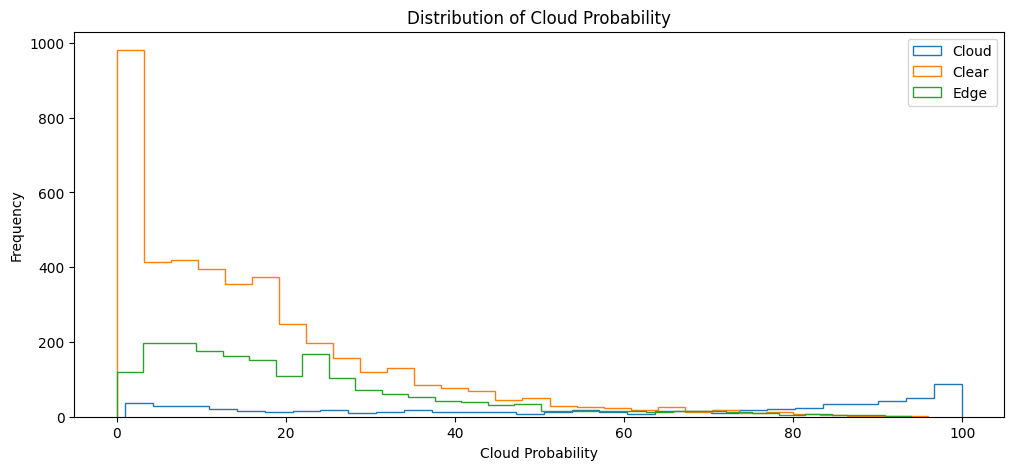

In [19]:
# Histogram of cloud probability by class
plt.figure(figsize=(12, 5))
plt.hist(cloud_df['probability'], bins=30, histtype='step', label='Cloud')
plt.hist(clear_df['probability'], bins=30, histtype='step', label='Clear')
plt.hist(edge_df['probability'], bins=30, histtype='step', label='Edge')
plt.xlabel('Cloud Probability')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Cloud Probability')
plt.show()

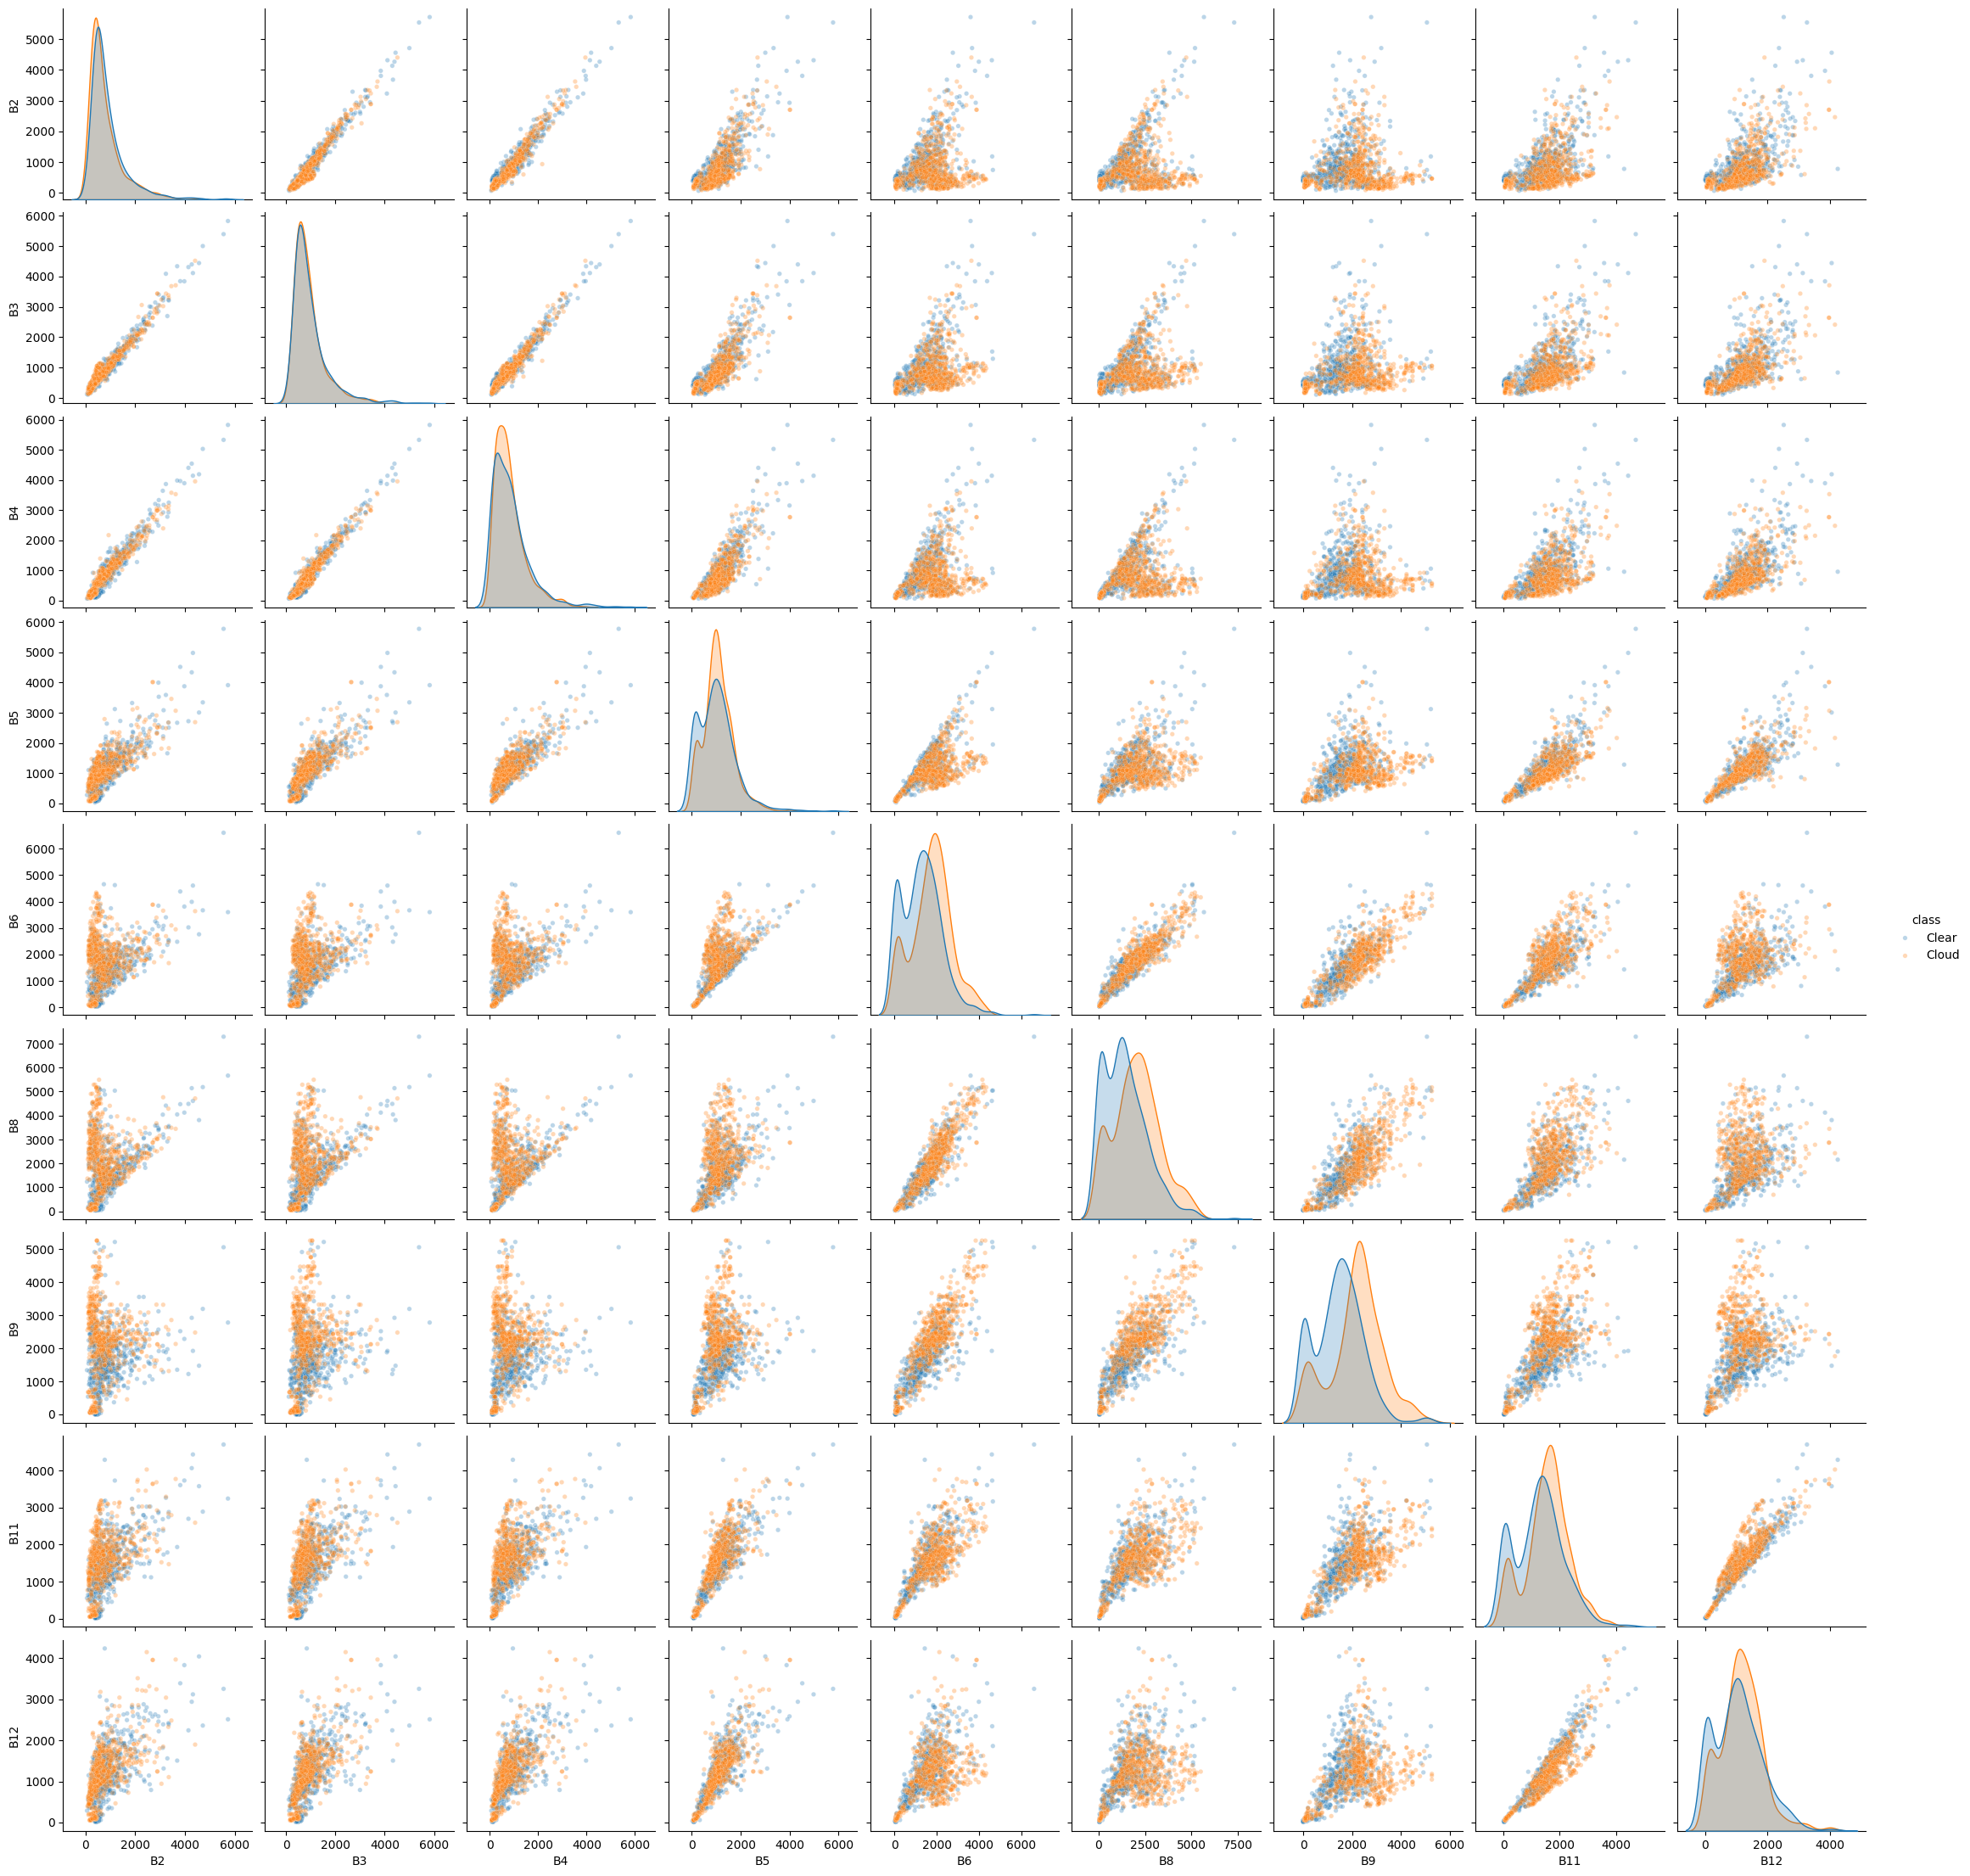

In [20]:
# Plot out all the bands, by the two 'labelled' classes that we want to discriminate between
# Add class labels
cloud_df['class'] = 'Cloud'
clear_df['class'] = 'Clear'

# Combine to one df
combined_df = pd.concat([cloud_df, clear_df])

# We will carry out somne class balancing here
# Find smallest class count
min_count = combined_df['class'].value_counts().min()

# Downsample each class to min_count
balanced_df = combined_df.groupby('class').sample(n=min_count, random_state=42)

# Now plot with balanced_df
# This is going to make a big plot that you will have to scroll around! Pay particular attention to the histogram plots on the diagonal.
bands = ['B2', 'B3', 'B4', 'B5', 'B6' , 'B8', 'B9', 'B11', 'B12']
sns.pairplot(balanced_df, vars=bands, hue='class', plot_kws={'alpha':0.3, 's':15}, height=2.5)


(4) What do the histograms of cloud detection probability (as judged by s2cloudless) plotted in the three classes we have set here, AND the pair plot of all bands available tell us about our ability to tell cloudy vs non-cloud pixels apart? Make sure to explain your answer with reference to physical principles and the statistical foundations of ML (5 pts)

(5) Which bands are therefore going to be the best to use in our K-means clustering approach and why? (5 pts)

With our choices made, let us now test if we can implement k-means as a tool by which to assign those edge pixels into either the cloudy or clear classes. Noting that I have placed default band choices in the 'features to use for clustering' line. You do not need to use just three bands.

Run this section first with the default bands, and then change it to the ones you have selected in question 5. Observe the difference it makes...

In [21]:
# Use the balanced_df from before for cloud and clear pixels only
train_df = balanced_df[balanced_df['class'].isin(['Cloud', 'Clear'])]

# Features to use for clustering
features = ['B2', 'B3', 'B4']

# Prepare training data (cloud=1, clear=0)
X_train = train_df[features].values
y_train = (train_df['class'] == 'Cloud').astype(int).values

# Fit k-means with 2 clusters on training data
kmeans = KMeans(n_clusters=2, random_state=42).fit(X_train)

# Map clusters to classes by majority vote on training data
labels, counts = np.unique(kmeans.labels_[y_train==0], return_counts=True)
clear_cluster = labels[np.argmax(counts)]
labels, counts = np.unique(kmeans.labels_[y_train==1], return_counts=True)
cloud_cluster = labels[np.argmax(counts)]

# Prepare edge pixels data for prediction
edge_features = edge_df[features].values

# Predict clusters for edge pixels
edge_clusters = kmeans.predict(edge_features)

# Assign class labels to edge pixels based on cluster
edge_df['predicted_class'] = ['Cloud' if c == cloud_cluster else 'Clear' for c in edge_clusters]

# Quick summary
print(edge_df['predicted_class'].value_counts())


predicted_class
Cloud    1485
Clear     370
Name: count, dtype: int64


And now plot up the results of this below. Play around with this plotting and take a look at each set of band combinations you have chosen. Think about where the boundary is being placed, does it make sense?

predicted_class
Cloud    1485
Clear     370
Name: count, dtype: int64


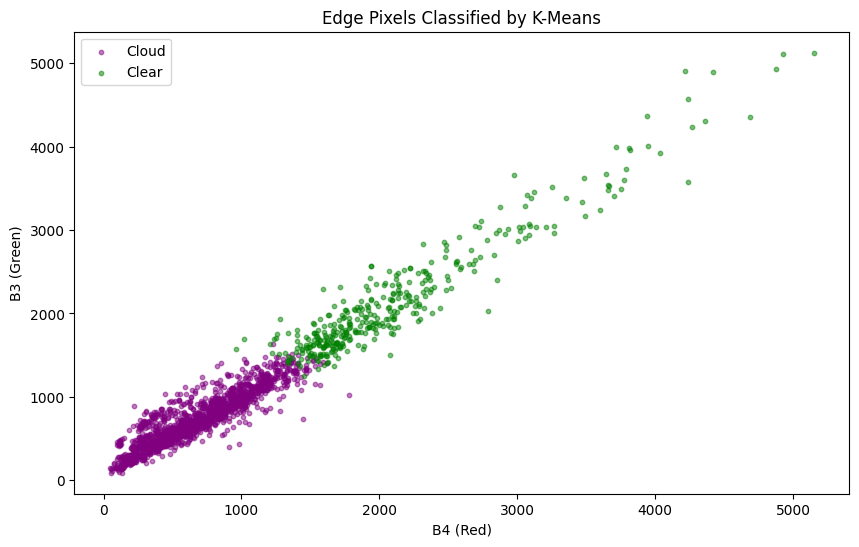

In [22]:
# Count of predicted classes
counts = edge_df['predicted_class'].value_counts()
print(counts)

# Scatter plot of edge pixels B4 vs B3 colored by predicted class ### CHANGE THIS TO YOUR OTHER BANDS ###
plt.figure(figsize=(10, 6))
for label, color in zip(['Cloud', 'Clear'], ['purple', 'green']):
    subset = edge_df[edge_df['predicted_class'] == label]
    plt.scatter(subset['B4'], subset['B3'], label=label, alpha=0.5, s=10, c=color)

plt.xlabel('B4 (Red)')
plt.ylabel('B3 (Green)')
plt.title('Edge Pixels Classified by K-Means')
plt.legend()
plt.show()


Finally, we will map this back onto earth engine via the following workflow:
1.  Export the classified edge pixels back to Earth Engine as a FeatureCollection
2. Rasterize the classified edge points into an image layer
3. Visualize refined cloud mask in Earth Engine (geemap):

Export to Earth Engine FC:

In [23]:
# Function to go the other way! This time from a dataframe to the feature collection
def df_to_ee_fc(df):
    features = []
    for _, row in df.iterrows():
        geom = ee.Geometry.Point([row['longitude'], row['latitude']])
        props = {k: float(row[k]) for k in ['B2', 'B3', 'B4', 'B8', 'probability']}
        props['predicted_class'] = row['predicted_class']
        features.append(ee.Feature(geom, props))
    return ee.FeatureCollection(features)

edge_fc = df_to_ee_fc(edge_df)

Rasterize into image layer:

In [24]:
# Map predicted class to numeric
def class_to_numeric(feature):
    cls = feature.get('predicted_class')
    return feature.set('cloud_refined', ee.Number(ee.Algorithms.If(ee.String(cls).equals('Cloud'), 1, 0)))

edge_fc_num = edge_fc.map(class_to_numeric)

# Rasterize: paint 'cloud_refined' on a blank image
refined_cloud_mask = edge_fc_num.reduceToImage(
    properties=['cloud_refined'],
    reducer=ee.Reducer.first())

# Optionally, you can combine this refined mask with your existing cloudmask for a final refined mask
final_mask = s2_sr_median.select('cloudmask').max(refined_cloud_mask).rename('cloudmask_refined')


Visualize it:

In [25]:
Map = geemap.Map()
Map.centerObject(AOI, 12)

# Show original cloudmask
Map.addLayer(s2_sr_median.select('cloudmask'), {'palette': ['white', 'red']}, 'Original cloudmask')

# Show refined cloudmask
Map.addLayer(final_mask.selfMask(), {'palette': ['blue']}, 'Refined cloudmask')

Map

Map(center=[-36.84850000000001, 174.7633], controls=(WidgetControl(options=['position', 'transparent_bg'], pos…

Hopefully, what you should now see above is a patch of downtown Auckland that has your s2cloudless cloudmask and a scatter of blue pixels (i.e. the sample from within the AOI) that k-means has decided is cloud.

Your answer to Q5 should see this scatter of 'new cloudy' pixels be better associated with the known clouds than if you leave it as the default bands that I have provided.





(6) Exercise: take all you have learned in this lab and carry out the following improvements:
1. Increase the K-means sampling to be more representative of the whole scene. This means; sample regions for cloud, clear and cloud edge that are not just over downtown Auckland but from across multiple landcover types.
2. Take the model that you have trained here using SciKitLearn and use it to classify edge pixels across a whole satellite image.

Present your results in **two** figures. The first should show the results of upgrades to pt.1, the second the results of pt.2.

(15 pts)

To get you started on item 2, this might be how you plan out your workflow given that you cannot upload a python ML model directly to Earth Engine:
- Extract cluster centres from Python k-means.
- Pass centres as constants into EE.
- Write a per-pixel classification function assigning nearest cluster centre.
- Apply this function to edge pixels or the whole image as needed.